In [1]:
import pyspark,ogr,json

### 下面这个一大个方法，主要用matplotlib绘制几何要素，做可视化用的

In [2]:
import matplotlib.pyplot as plt
def show(polyArr,poly2=None,polyArr2=None, 
         xm=(11135007,11138992),ym=(2709657, 2713334)):  
    fig = plt.figure(figsize=(12,9)) 
    ax = fig.gca() 
    ax.grid(alpha= 1)
    for i in range(len(polyArr)):
        px = json.loads(polyArr[i].ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                            ec = '#000000',fc='gray', alpha = 0.5)
        ax.add_patch(mpoly)
        if len(px["coordinates"]) > 1:
            mpoly = plt.Polygon(px["coordinates"][1],
                                ec = '#000000',fc='white', alpha = 1)
            ax.add_patch(mpoly)
    
    if poly2:
        px = json.loads(poly2.ExportToJson())
        mpoly = plt.Polygon(px["coordinates"][0],
                                ec = '#000000',fc='blue', alpha = 0.2)
        ax.add_patch(mpoly)
    
    if polyArr2:
        for i in range(len(polyArr2)):
            px = json.loads(polyArr2[i].ExportToJson())
            mpoly = plt.Polygon(px["coordinates"][0],
                                ec = '#000000',fc='red', alpha = 0.5,hatch='/')
            ax.add_patch(mpoly)
            if len(px["coordinates"]) > 1:
                mpoly = plt.Polygon(px["coordinates"][1],
                                    ec = '#000000',fc='white', alpha = 1)
                ax.add_patch(mpoly)

    ax.set_autoscale_on= False
    ax.set_xlim(xm[0],xm[1])
    ax.set_ylim(ym[0],ym[1])

### 查看一下示例数据情况

In [3]:
poly = [row.split("\t")[1] for row in open("./data/dltb.tsv",encoding="utf-8")][1:]

In [4]:
p = []
for pl in poly:
    p.append(ogr.CreateGeometryFromWkt(pl))

### 构建一个用来选择的要素，这里直接构建了一条线，然后进行缓冲。

In [5]:
line = 'LINESTRING(11136593  2713221,11138504 2712110, 11135386 2710566)'
buf = ogr.CreateGeometryFromWkt(line).Buffer(100)

### 用于计算的和选择的数据如下

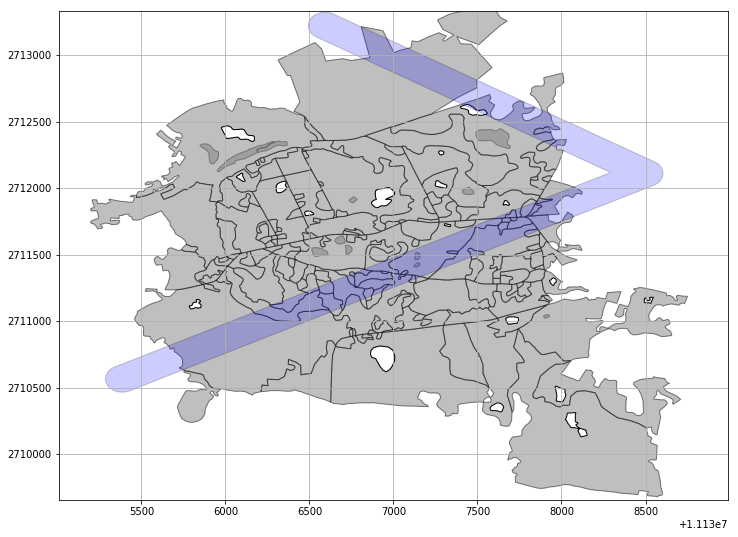

In [6]:
show(p,buf)

In [7]:
sc = pyspark.SparkContext()

# 标准流程：清洗过滤、计算、提交、可视化

### 1、过滤掉头，且进行清洗

In [8]:
def filterHeader(line):
    geoline = line.split("\t")
    try:
        return ogr.CreateGeometryFromWkt(geoline[1]).IsValid()
    except:
        return False

In [9]:
rdd = sc.textFile("./data/dltb.tsv").filter(lambda line : filterHeader(line))

### 2、进行空间选择，如果相交的，就选择出来

In [10]:
def SelectByLocation(line,selectGeom):
    return selectGeom.Intersects(ogr.CreateGeometryFromWkt(line.split("\t")[1]))

In [11]:
res = rdd.filter(lambda line : SelectByLocation(line,buf)).collect()

### 3、可视化

In [12]:
p2 = []
for pl in res:
    p2.append(ogr.CreateGeometryFromWkt(pl.split("\t")[1]))

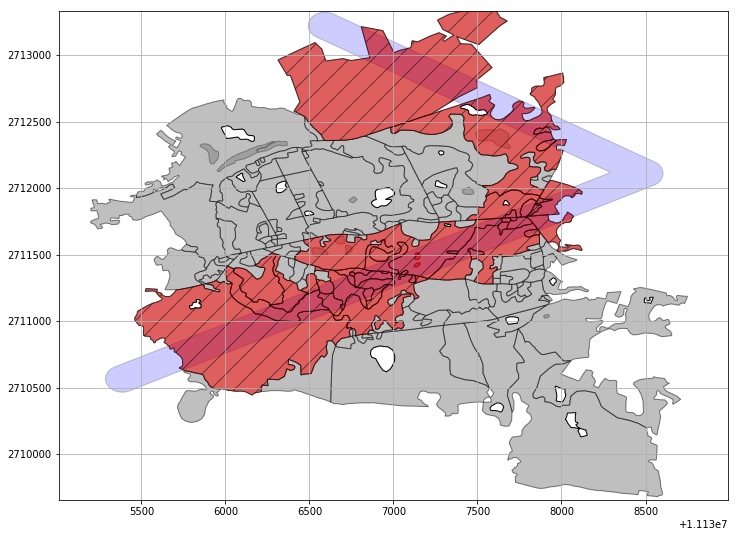

In [13]:
show(p,buf,p2)

## 实际上可以写成一个方法，同时进行过滤和选择

In [14]:
def SelectByLocaiton2(line,selectGeom):
    try:
        return selectGeom.Intersects(ogr.CreateGeometryFromWkt(line.split("\t")[1]))
    except:
        return False

### 将缓冲的距离调整到200米

In [15]:
buf = ogr.CreateGeometryFromWkt(line).Buffer(200)

In [16]:
res2 = rdd.filter(lambda line : SelectByLocaiton2(line,buf)).collect()

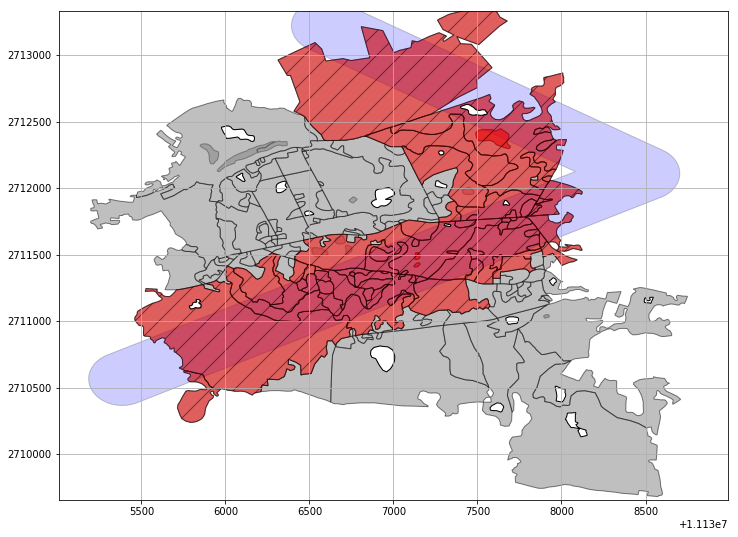

In [17]:
p2 = []
for pl in res2:
    p2.append(ogr.CreateGeometryFromWkt(pl.split("\t")[1]))
show(p,buf,p2)

# 计算完全包含的要素

### 将空间关系换成contains即可

In [18]:
def SelectByLocaiton3(line,selectGeom):
    try:
        return selectGeom.Contains(ogr.CreateGeometryFromWkt(line.split("\t")[1]))
    except:
        return False

### 缓冲距离调整到400米

In [19]:
buf = ogr.CreateGeometryFromWkt(line).Buffer(400)

In [20]:
res3 = rdd.filter(lambda line : SelectByLocaiton3(line,buf)).collect()

### 只有完全被包含的才被选择了

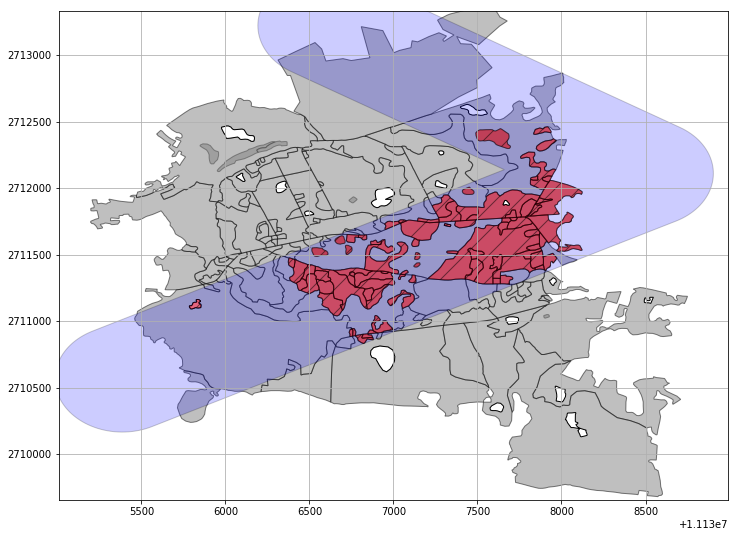

In [21]:
p2 = []
for pl in res3:
    p2.append(ogr.CreateGeometryFromWkt(pl.split("\t")[1]))
show(p,buf,p2)